In [2]:
!pip install cairocffi

  Obtaining dependency information for cairocffi from https://files.pythonhosted.org/packages/93/d8/ba13451aa6b745c49536e87b6bf8f629b950e84bd0e8308f7dc6883b67e2/cairocffi-1.7.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/75.6 kB ? eta -:--:--
   ---------------------------------------- 75.6/75.6 kB 2.1 MB/s eta 0:00:00


In [3]:
import json
import sqlite3
from sqlite3 import Connection

import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cairocffi as cairo

In [4]:
def build_response_relations(conn: Connection, response_type: str):
    cur = conn.cursor()
    query = """
            SELECT
                t1.author_id as source_author,
                t2.author_id as dest_author
            FROM tweets t1
            JOIN referenced_tweets rt ON t1.id = rt.tweet_id
            JOIN tweets t2 ON rt.referenced_tweet_id = t2.id
            WHERE
                rt.referenced_tweet_type = ?
                AND t1.author_id != t2.author_id
            """
    result = cur.execute(query, [response_type]).fetchall()
    return result

In [5]:
conn = sqlite3.connect(f"D:/UU/Sem3/SDM/social_data_mining/data/twitter.db")
retweet_edges = build_response_relations(conn, "retweeted")
print(len(retweet_edges))

1385201


In [6]:
reply_edges = build_response_relations(conn, "replied_to")
print(len(reply_edges))

38290


In [7]:
def get_distinct_authors(conn: Connection):
    cur = conn.cursor()
    result = cur.execute("SELECT DISTINCT author_id FROM tweets")
    return result.fetchall()

In [8]:
authors = get_distinct_authors(conn)
authors_list = [''.join(author) for author in authors]
# print(authors[:10])
# print(authors_list[:10])
print(len(authors_list))
conn.close()

481467


In [9]:
print(retweet_edges[:3])
print(authors_list[:3])

[('1011975294', '1471250628'), ('255144027', '313743136'), ('214748274', '4010449719')]
['1011975294', '255144027', '214748274']


In [10]:
retweet_graph = ig.Graph(n=len(authors_list))
retweet_graph["title"] = "Retweet network"
retweet_graph.vs["name"] = authors_list
retweet_graph.add_edges(retweet_edges)
retweet_graph.summary()

'IGRAPH UN-- 481467 1385201 -- \n+ attr: title (g), name (v)'

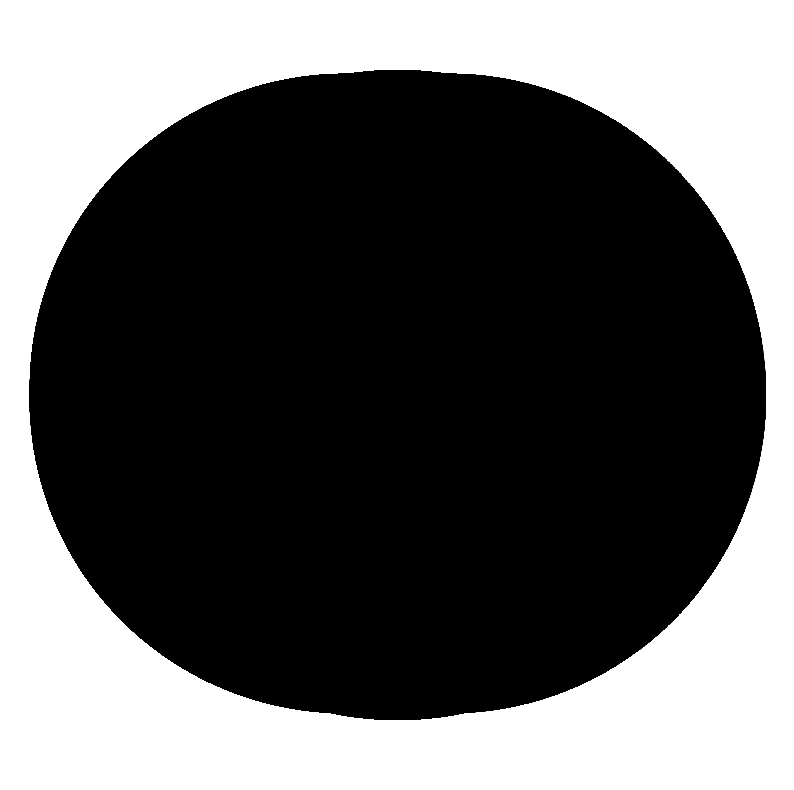

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
layout = retweet_graph.layout("circle")
visual_style = {
    "vertex_size": 20,
    "vertex_label": retweet_graph.vs["name"],  # Show vertex names
    "vertex_color": "red",
    "edge_color": "black",
    "bbox": (300, 300),  # Width and height of the plot
    "margin": 20,  # Margin around the graph
}

ig.plot(retweet_graph, target=ax, layout=layout, **visual_style)

In [14]:
reply_graph = ig.Graph(n=len(authors_list))
reply_graph["title"] = "Reply network"
reply_graph.vs["name"] = authors_list
reply_graph.add_edges(reply_edges)
reply_graph.summary()

'IGRAPH UN-- 481467 38290 -- \n+ attr: title (g), name (v)'

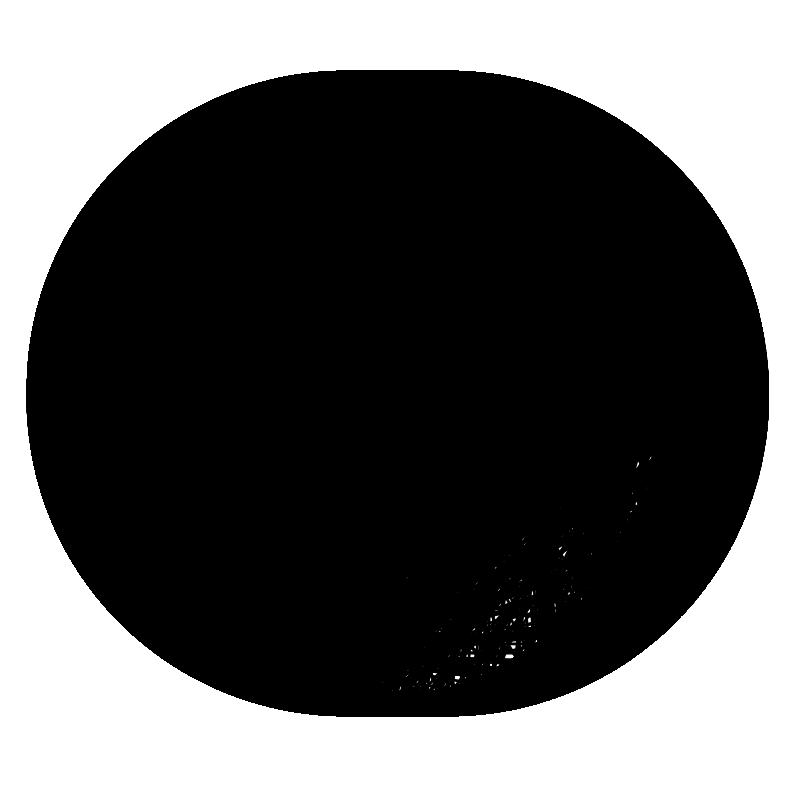

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
layout = reply_graph.layout("circle")
visual_style = {
    "vertex_size": 5,
    "vertex_label": reply_graph.vs["name"],  # Show vertex names
    "vertex_color": "red",
    "edge_color": "black",
    "bbox": (300, 300),  # Width and height of the plot
    "margin": 20,  # Margin around the graph
}

ig.plot(reply_graph, target=ax, layout=layout, **visual_style)
plt.show()

In [18]:
def analyze_graph(g: ig.Graph):
    order = g.vcount()
    size = g.ecount()
    components = g.components()
    no_components = len(components)
    size_of_largest_component = max([len(component) for component in components])
    density = g.density()
    transitivity = g.transitivity_undirected()
    
    print(f"Order: {order}")
    print(f"Size: {size}")
    print(f"No .of Components: {no_components}")
    print(f"Size of largest component: {size_of_largest_component}")
    print(f"Density: {density}")
    print(f"Transitivity: {transitivity}")
    
    degree_dist = g.degree()
    degree_counts = np.bincount(degree_dist)
    degrees = np.arange(len(degree_counts))
    
    non_zero = degree_counts > 0
    degrees = degrees[non_zero]
    degree_counts = degree_counts[non_zero]
    
    plt.figure(figsize=(8, 6))
    plt.loglog(degrees, degree_counts, marker="o", linestyle="", markersize=6, alpha=0.7, label="Degree Distribution")
    plt.title("Degree Distribution (Log-Log Scale)")
    plt.xlabel("Degree (log)")
    plt.ylabel("Frequency (log)")
    plt.grid(which="both", linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()
    
    # return {
    #     "order": order,
    #     "size": size,
    #     "components": len(g.components()),
    #     "density": density,
    #     "clustering_coefficient": transitivity
    # }

Analyzing retweet graph:
Order: 481467
Size: 1385201
No .of Components: 152103
Size of largest component: 328823
Density: 1.1951176015176777e-05
Transitivity: 0.005775000608283903


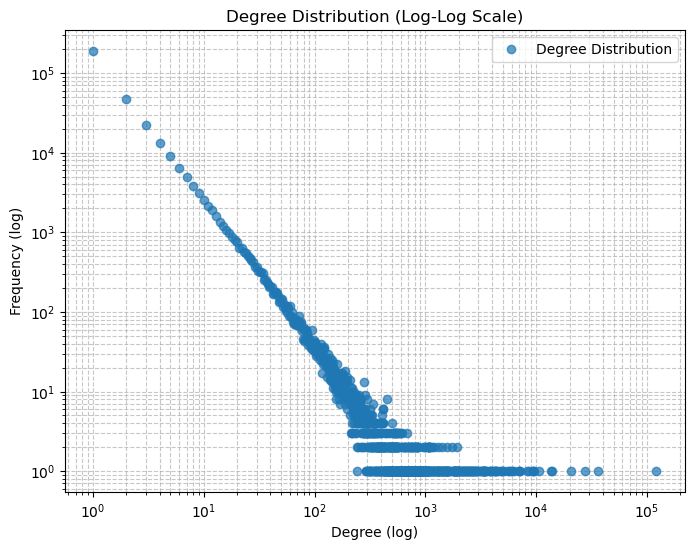

In [19]:
print("Analyzing retweet graph:")
analyze_graph(retweet_graph)

Analyzing reply graph:
Order: 481467
Size: 38290
No .of Components: 454492
Size of largest component: 24553
Density: 3.3035677105425044e-07
Transitivity: 9.069276620824662e-05


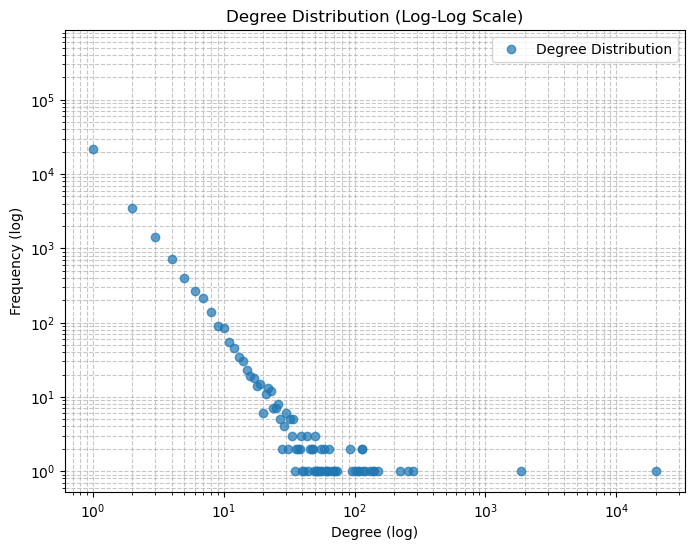

In [20]:
print("Analyzing reply graph:")
analyze_graph(reply_graph)

In [29]:
def prepare_graph(g: ig.Graph):
    layout = g.layout("circle")
    
    g.vs["color"] = "red"
    g.vs["size"] = 1
    g.vs["frame_width"] = 0
    g.vs["label"] = None
    
    g.es["color"] = "rgba(0, 0, 0, 0.1)"
    g.es["width"] = 0.5
    
    return g, layout

In [28]:
def plot_graph(g: ig.Graph, layout: ig.Layout, target_file = None):
    visual_style = {
        "layout": layout,
        "vertex_color": g.vs["color"],
        "vertex_size": g.vs["size"],
        "vertex_frame_width": 0,
        "vertex_label": None,
        "edge_color": g.es["color"],
        "edge_width": g.es["width"],
        # "bbox": (800, 800),  # Image size in pixels
        "margin": 2,
    }

    # Use matplotlib as the engine for visualization
    plt.figure(figsize=(10, 10))
    ig_plot = ig.plot(g, target=target_file, **visual_style, backend="matplotlib")

    if target_file is None:
        plt.show()  # Show plot interactively
    else:
        print(f"Plot saved to: {target_file}")

In [30]:
reply_graph, layout = prepare_graph(reply_graph)

Plot saved to: reply_graph.png


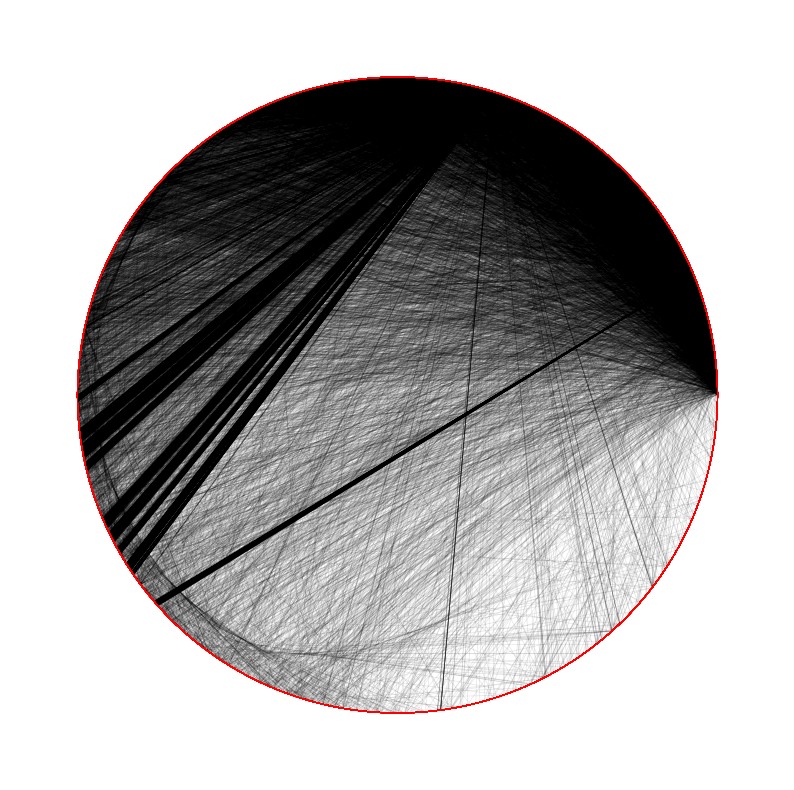

In [31]:
plot_graph(reply_graph, layout, "reply_graph.png")